# Vehicle Routing Problem

In [1]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns

In [2]:
np.random.seed(45)

n_cars = 2
cars_set = list(range(1, n_cars+1))

n_customers = 30
customers_set = list(range(1, n_customers+1))
warehouse = 0
points_set = [warehouse] + customers_set

In [3]:
coordinates = {
    i: (np.random.randint(10, 80), np.random.randint(10, 80)) for i in points_set
}

coordinates

{0: (40, 13),
 1: (42, 71),
 2: (45, 78),
 3: (25, 75),
 4: (24, 63),
 5: (67, 56),
 6: (18, 63),
 7: (22, 44),
 8: (34, 22),
 9: (27, 78),
 10: (40, 66),
 11: (24, 46),
 12: (41, 46),
 13: (67, 71),
 14: (27, 16),
 15: (52, 21),
 16: (18, 59),
 17: (73, 52),
 18: (64, 26),
 19: (34, 73),
 20: (32, 37),
 21: (42, 26),
 22: (68, 70),
 23: (64, 42),
 24: (26, 69),
 25: (65, 15),
 26: (77, 65),
 27: (70, 67),
 28: (37, 28),
 29: (65, 30),
 30: (19, 19)}

In [4]:
distances = {
    (i, j): math.dist((coordinates[i][0], coordinates[i][1]), (coordinates[j][0], coordinates[j][1]))
    for i in points_set for j in points_set if i != j
}

distances

{(0, 1): 58.034472514187634,
 (0, 2): 65.19202405202648,
 (0, 3): 63.788713735268246,
 (0, 4): 52.49761899362675,
 (0, 5): 50.774009099144415,
 (0, 6): 54.62600113499065,
 (0, 7): 35.84689665786984,
 (0, 8): 10.816653826391969,
 (0, 9): 66.2872536767062,
 (0, 10): 53.0,
 (0, 11): 36.6742416417845,
 (0, 12): 33.015148038438355,
 (0, 13): 63.97655820689325,
 (0, 14): 13.341664064126334,
 (0, 15): 14.422205101855956,
 (0, 16): 50.99019513592785,
 (0, 17): 51.088159097779204,
 (0, 18): 27.294688127912362,
 (0, 19): 60.29925372672534,
 (0, 20): 25.298221281347036,
 (0, 21): 13.152946437965905,
 (0, 22): 63.50590523722971,
 (0, 23): 37.64306044943742,
 (0, 24): 57.723478758647246,
 (0, 25): 25.079872407968907,
 (0, 26): 63.8200595424354,
 (0, 27): 61.773780845922005,
 (0, 28): 15.297058540778355,
 (0, 29): 30.23243291566195,
 (0, 30): 21.840329667841555,
 (1, 0): 58.034472514187634,
 (1, 2): 7.615773105863909,
 (1, 3): 17.46424919657298,
 (1, 4): 19.697715603592208,
 (1, 5): 29.1547594742265

In [5]:
model = pyo.ConcreteModel()

In [6]:
model.cars = pyo.Set(initialize=cars_set)
model.customers = pyo.Set(initialize=customers_set)
model.points = pyo.Set(initialize=points_set)
model.flows = pyo.Set(initialize=distances.keys())

In [7]:
model.distances = pyo.Param(model.flows, initialize=distances)

In [8]:
model.assignment = pyo.Var(model.flows, model.cars, domain=pyo.Binary)
model.sum_mileage = pyo.Var(domain=pyo.NonNegativeReals)
model.visit = pyo.Var(model.customers, model.cars, bounds=(0, n_customers))

In [9]:
model.visit.display()

visit : Size=60, Index=customers*cars
    Key     : Lower : Value : Upper : Fixed : Stale : Domain
     (1, 1) :     0 :  None :    30 : False :  True :  Reals
     (1, 2) :     0 :  None :    30 : False :  True :  Reals
     (2, 1) :     0 :  None :    30 : False :  True :  Reals
     (2, 2) :     0 :  None :    30 : False :  True :  Reals
     (3, 1) :     0 :  None :    30 : False :  True :  Reals
     (3, 2) :     0 :  None :    30 : False :  True :  Reals
     (4, 1) :     0 :  None :    30 : False :  True :  Reals
     (4, 2) :     0 :  None :    30 : False :  True :  Reals
     (5, 1) :     0 :  None :    30 : False :  True :  Reals
     (5, 2) :     0 :  None :    30 : False :  True :  Reals
     (6, 1) :     0 :  None :    30 : False :  True :  Reals
     (6, 2) :     0 :  None :    30 : False :  True :  Reals
     (7, 1) :     0 :  None :    30 : False :  True :  Reals
     (7, 2) :     0 :  None :    30 : False :  True :  Reals
     (8, 1) :     0 :  None :    30 : False :  

In [10]:
def assign_route(model, j):
    eq = sum(
        model.assignment[i, j, c]
        for i in model.points
        for c in model.cars
        if i != j
    ) >= 1

    return eq

model.assign_route = pyo.Constraint(
    model.customers, rule=assign_route
)

In [11]:
def balance_round_trip(model, j, c):
    eq = sum(
        model.assignment[i, j, c]
        for i in model.points
        if j != i
    ) - sum(
        model.assignment[j, i, c]
        for i in model.points
        if j != i
    ) == 0

    return eq

model.balance_round_trip = pyo.Constraint(
    model.points, model.cars, rule=balance_round_trip
)

In [12]:
def vehicle_leave(model, c):
    eq = sum(
        model.assignment[warehouse, j, c]
        for j in model.customers
    ) == 1

    return eq

model.vehicle_leave = pyo.Constraint(
    model.cars, rule=vehicle_leave
)

In [13]:
def vehicle_return(model, c):
    eq = sum(
        model.assignment[i, warehouse, c]
        for i in model.customers
    ) == 1

    return eq

model.vehicle_return = pyo.Constraint(
    model.cars, rule=vehicle_return
)

In [14]:
def route_preceedence(model, i, j, c):
    if i != j and i != warehouse and j != warehouse:
        eq = model.visit[i, c] + 1 <= model.visit[j, c] + len(model.customers) * (1 - model.assignment[i, j, c])
    else:
        eq = pyo.Constraint.Skip
    return eq

model.route_preceedence = pyo.Constraint(
    model.customers, model.customers, model.cars, rule=route_preceedence
)

In [15]:
def point_visit_max_limit(model, i, j):
    eq = sum(
        model.assignment[i, j, c]
        for c in model.cars
        if i != j
    ) <= 1

    return eq

model.point_visit_max_limit = pyo.Constraint(
    model.flows, rule=point_visit_max_limit
)

In [16]:
def point_visit_lower_limit(model, i, j):
    eq = sum(
        model.assignment[i, j, c]
        for c in model.cars
        if i != j
    ) >= 0

    return eq

model.point_visit_lower_limit = pyo.Constraint(
    model.flows, rule=point_visit_lower_limit
)

In [17]:
def objective_function(model):
    eq = sum(
        model.assignment[i, j, c] * model.distances[i, j]
        for i, j in model.flows
        for c in model.cars
        if j != i
    )

    return eq

model.objective_function = pyo.Objective(
    rule=objective_function, sense=pyo.minimize
)

In [18]:
solver = pyo.SolverFactory("appsi_highs")
solver.solve(model, tee=False)

{'Problem': [{'Lower bound': 307.1963115279801, 'Upper bound': 307.20442772865147, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [19]:
model.assignment.display()

assignment : Size=1860, Index=flows*cars
    Key         : Lower : Value             : Upper : Fixed : Stale : Domain
      (0, 1, 1) :     0 :               0.0 :     1 : False : False : Binary
      (0, 1, 2) :     0 :               0.0 :     1 : False : False : Binary
      (0, 2, 1) :     0 :               0.0 :     1 : False : False : Binary
      (0, 2, 2) :     0 :               0.0 :     1 : False : False : Binary
      (0, 3, 1) :     0 :               0.0 :     1 : False : False : Binary
      (0, 3, 2) :     0 :               0.0 :     1 : False : False : Binary
      (0, 4, 1) :     0 :               0.0 :     1 : False : False : Binary
      (0, 4, 2) :     0 :               0.0 :     1 : False : False : Binary
      (0, 5, 1) :     0 :               0.0 :     1 : False : False : Binary
      (0, 5, 2) :     0 :               0.0 :     1 : False : False : Binary
      (0, 6, 1) :     0 :               0.0 :     1 : False : False : Binary
      (0, 6, 2) :     0 :          

In [20]:
data = model.assignment.extract_values()

In [21]:
data = {key: value for key, value in data.items() if value is not None and value >= 0.9}

In [22]:
output_list = list()
for key, value in data.items():
    output_list.append(
        [key[0], key[1], key[2], value]
    )


In [23]:
coordinates_x = {
    i: coordinates[i][0]
    for i in coordinates.keys()
}

coordinates_y = {
    i: coordinates[i][1]
    for i in coordinates.keys()
}

In [24]:
route_columns = ["origin", "destination", "car", "status"]
route_df = pd.DataFrame(data=output_list, columns=route_columns)

route_df["origin_x"] = route_df["origin"].map(coordinates_x)
route_df["origin_y"] = route_df["origin"].map(coordinates_y)
route_df["destination_x"] = route_df["destination"].map(coordinates_x)
route_df["destination_y"] = route_df["destination"].map(coordinates_y)

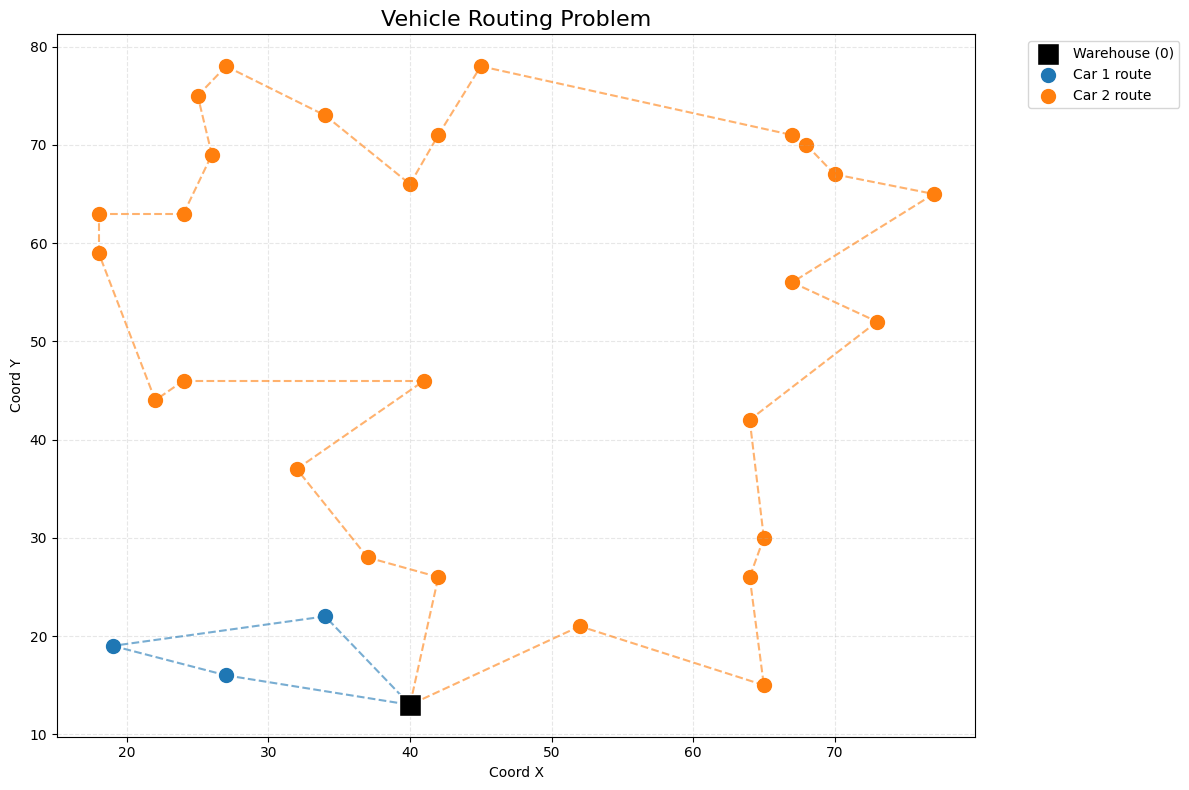

In [28]:
plt.figure(figsize=(12, 8))

palette = sns.color_palette("tab10", n_colors=route_df['car'].nunique())

warehouse_x = route_df.loc[route_df["origin"] == warehouse, "origin_x"].iloc[0]
warehouse_y = route_df.loc[route_df["origin"] == warehouse, "origin_y"].iloc[0]

plt.scatter(warehouse_x, warehouse_y,
            color='black', s=250, marker='s', edgecolor='white', zorder=5, label='Warehouse (0)')

for i, (car_id, group) in enumerate(route_df.groupby("car")):
    color = palette[i]
    
    plt.scatter(group["origin_x"], group["origin_y"], 
                marker='o', s=100, color=color, label=f'Car {car_id} route')

    for _, row in group.iterrows():
        plt.plot([row["origin_x"], row["destination_x"]],
                 [row["origin_y"], row["destination_y"]],
                 linestyle='--', color=color, alpha=0.6)

plt.title("Vehicle Routing Problem", fontsize=16)
plt.xlabel("Coord X")
plt.ylabel("Coord Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
route_df.loc[route_df["car"]==1].sort_values(by=["origin", "destination"], ascending=True)

,origin,destination,car,status,origin_x,origin_y,destination_x,destination_y
0,0,8,1,1.0,40,13,34,22
9,8,30,1,1.0,34,22,19,19
15,14,0,1,1.0,27,16,40,13
31,30,14,1,1.0,19,19,27,16


In [27]:
model.point_visit_max_limit.display()

point_visit_max_limit : Size=930
    Key      : Lower : Body              : Upper
      (0, 1) :  None :               0.0 :   1.0
      (0, 2) :  None :               0.0 :   1.0
      (0, 3) :  None :               0.0 :   1.0
      (0, 4) :  None :               0.0 :   1.0
      (0, 5) :  None :               0.0 :   1.0
      (0, 6) :  None :               0.0 :   1.0
      (0, 7) :  None :               0.0 :   1.0
      (0, 8) :  None :               1.0 :   1.0
      (0, 9) :  None :               0.0 :   1.0
     (0, 10) :  None :               0.0 :   1.0
     (0, 11) :  None :               0.0 :   1.0
     (0, 12) :  None :               0.0 :   1.0
     (0, 13) :  None :               0.0 :   1.0
     (0, 14) :  None :               0.0 :   1.0
     (0, 15) :  None :               0.0 :   1.0
     (0, 16) :  None :               0.0 :   1.0
     (0, 17) :  None :               0.0 :   1.0
     (0, 18) :  None :               0.0 :   1.0
     (0, 19) :  None :              